# To Ilustrate Callback

1. Learning rate schedule
2. Learning rate finder

## Setup Env and Load Modules

In [1]:
import os
import sys
import inspect

current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0,parent_dir) 

In [2]:
import gzip
import pickle
import matplotlib.pyplot as plt
from fastai import datasets
from torch import tensor, nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from functools import partial
from Henry.databunch import Dataset, DataBunch
from Henry.callbacks import AvgStatsCallback, ParamScheduler, Recorder, LR_Find
from Henry.trainer import Learner, Trainer
from Henry.utils import accuracy
from Henry.lr_scheduler import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Define functions

* get data
* data loader
* define NN model

In [3]:
def get_data(URL):
    path = datasets.download_data(URL, ext=".gz")
    with gzip.open(path, "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")
    return map(tensor, (x_train, y_train, x_valid, y_valid))

def get_dls(train_ds, valid_ds, bs, **kwargs):
    """Create a train and validation dataloaders"""
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
        DataLoader(valid_ds, batch_size=bs * 2, **kwargs),
    )

def get_model(data, lr=0.5, nh=50):
    """Create a model and optmizer object"""
    m = data.train_ds.x.shape[1]
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, data.c))
    return model, optim.SGD(model.parameters(), lr=lr)

## Model Setup

In [4]:
MNIST_URL = "http://deeplearning.net/data/mnist/mnist.pkl"
x_train,y_train,x_valid,y_valid = get_data(MNIST_URL)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
c = y_train.max().item()+1
nh, bs, epoches = 50, 64, 5

### Define dataset, loss function and model learner

In [5]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)
loss_func = F.cross_entropy
learner = Learner(*get_model(data), loss_func, data)

## Training with a LR Scheduler

### Callbacks with learning rate scheduler

In [6]:
# Define callback
lr_sche = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)])
acc_cbf = partial(AvgStatsCallback,accuracy)
cbfs = [Recorder, 
        partial(AvgStatsCallback,accuracy), 
        partial(ParamScheduler, 'lr', lr_sche)]

### Training

In [7]:
# Training
train = Trainer(cb_funcs=cbfs)
train.fit(epoches, learner)
loss, acc = train.avg_stats.valid_stats.avg_stats
print(f"Final Loss: {loss} | Final Accuracy {acc}")

---- epoch: 0 ----
train: [0.3518508984375, tensor(0.8963)]
valid: [0.20276480712890624, tensor(0.9414)]
---- epoch: 1 ----
train: [0.170858828125, tensor(0.9491)]
valid: [0.13862003173828125, tensor(0.9584)]
---- epoch: 2 ----
train: [0.113511826171875, tensor(0.9655)]
valid: [0.118348681640625, tensor(0.9661)]
---- epoch: 3 ----
train: [0.078715546875, tensor(0.9761)]
valid: [0.1530478271484375, tensor(0.9523)]
---- epoch: 4 ----
train: [0.0591298291015625, tensor(0.9827)]
valid: [0.08801708984375, tensor(0.9743)]
Final Loss: 0.08801708984375 | Final Accuracy 0.9743000268936157


### Learning rate schedule

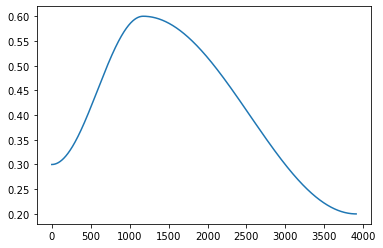

In [8]:
train.recorder.plot_lr()

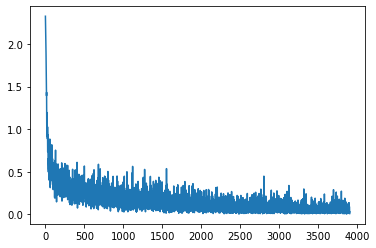

In [9]:
train.recorder.plot_loss()

## Training with a LR Scheduler

### Callbacks with Learning Rate Finder

In [10]:
# Define callback
cbfs = [Recorder, LR_Find]

### Training

In [11]:
# Training
train = Trainer(cb_funcs=cbfs)
train.fit(2, learner)

---- epoch: 0 ----


### Learning rate schedule

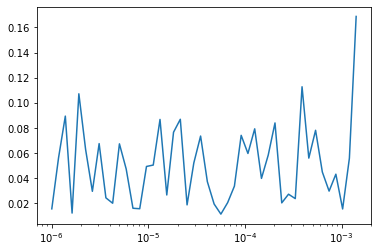

In [16]:
train.recorder.plot(skip_last=0)

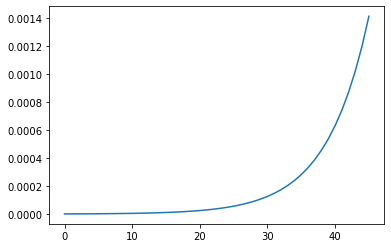

In [15]:
train.recorder.plot_lr()